In [45]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

from metrics_and_validation import mape, wape, smape, bias
from metrics_and_validation import GroupTimeSeriesSplit
from typing import Any

from dataclasses import dataclass
from typing import List

import matplotlib.pyplot as plt

In [12]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### SQL query to select features



```
with features as (
select date_trunc('week', dt)::date as monday,
    product_name,
    max(price) as max_price,
    count(user_id) as y,
    lagInFrame(y, 1) over w as y_lag_1,
    lagInFrame(y, 2) over w as y_lag_2,
    lagInFrame(y, 3) over w as y_lag_3,
    lagInFrame(y, 4) over w as y_lag_4,
    lagInFrame(y, 5) over w as y_lag_5,
    lagInFrame(y, 6) over w as y_lag_6,
    sum(y) over w1 as y_sum_3,
    max(y) over w1 as y_max_3,
    sum(y) over w2 as y_sum_6,
    max(y) over w2 as y_max_6
from default.data_sales_train
group by monday, product_name
window w as (
partition by product_name
    order by date_trunc('week', dt)::date
    rows between unbounded preceding and unbounded following
),
w1 as (
partition by product_name
    order by date_trunc('week', dt)::date
    rows between 3 preceding and 1 preceding
    ),
w2 as (
partition by product_name
    order by date_trunc('week', dt)::date
    rows between 6 preceding and 1 preceding
)
order by product_name, monday 
),

new_features as(
select 
    product_name,
    monday,
    max_price,
    y,
    y_lag_1,
    y_lag_2,
    y_lag_3,
    y_lag_4,
    y_lag_5,
    y_lag_6,
    y_sum_3 / 3 as y_avg_3,
    y_max_3,
    case 
        when y_lag_1 <= y_lag_2 and y_lag_1 <= y_lag_3 then y_lag_1
        when y_lag_2 <= y_lag_1 and y_lag_2 <= y_lag_3 then y_lag_2
        else y_lag_3
    end as y_min_3,
    case 
        when (y_lag_1 <= y_lag_2 and y_lag_1 <= y_lag_3
        and y_lag_1 <= y_lag_4
        and y_lag_1 <= y_lag_5
        and y_lag_1 <= y_lag_6) then y_lag_1
        when (y_lag_2 <= y_lag_1 and y_lag_2 <= y_lag_3
        and y_lag_2 <= y_lag_4
        and y_lag_2 <= y_lag_5
        and y_lag_2 <= y_lag_6) then y_lag_2
        when (y_lag_3 <= y_lag_1 and y_lag_3 <= y_lag_2
        and y_lag_3 <= y_lag_4
        and y_lag_3 <= y_lag_5
        and y_lag_3 <= y_lag_6) then y_lag_3
        when (y_lag_4 <= y_lag_1 and y_lag_4 <= y_lag_2
        and y_lag_4 <= y_lag_3
        and y_lag_4 <= y_lag_5
        and y_lag_4 <= y_lag_6) then y_lag_4
        when (y_lag_5 <= y_lag_1 and y_lag_5 <= y_lag_2
        and y_lag_5 <= y_lag_3
        and y_lag_5 <= y_lag_4
        and y_lag_5 <= y_lag_6) then y_lag_5
        else y_lag_6
    end as y_min_6,
    y_sum_6 / 6 as y_avg_6,
    y_max_6
from features
),

all_features as (
select 
    monday,
    sum(y_lag_1) as y_all_lag_1,
    sum(y_lag_2) as y_all_lag_2,
    sum(y_lag_3) as y_all_lag_3,
    sum(y_lag_4) as y_all_lag_4,
    sum(y_lag_5) as y_all_lag_5,
    sum(y_lag_6) as y_all_lag_6
from features
group by monday
window w1 as (
    order by monday
    rows between 3 preceding and 1 preceding
),
w2 as (
    order by monday
    rows between 6 preceding and 1 preceding)
),

new_all_features as (
select 
    monday,
    y_all_lag_1,
    y_all_lag_2,
    y_all_lag_3,
    y_all_lag_4,
    y_all_lag_5,
    y_all_lag_6,
    (y_all_lag_1 + y_all_lag_2 + y_all_lag_3) / 3 as y_all_avg_3,
    case
        when y_all_lag_1 >= y_all_lag_2 and y_all_lag_1 >= y_all_lag_3 then y_all_lag_1
        when y_all_lag_2 >= y_all_lag_3 and y_all_lag_2 >= y_all_lag_1 then y_all_lag_2
        else y_all_lag_3
    end as y_all_max_3,
    case
        when y_all_lag_1 <= y_all_lag_2 and y_all_lag_1 <= y_all_lag_3 then y_all_lag_1
        when y_all_lag_2 <= y_all_lag_1 and y_all_lag_2 <= y_all_lag_3 then y_all_lag_2
        else y_all_lag_3
    end as y_all_min_3,
    (y_all_lag_1 + y_all_lag_2 + y_all_lag_3 + y_all_lag_4 + y_all_lag_5 + y_all_lag_6 ) / 6 as y_all_avg_6,
     case 
        when (y_all_lag_1 >= y_all_lag_2 and y_all_lag_1 >= y_all_lag_3
        and y_all_lag_1 >= y_all_lag_4
        and y_all_lag_1 >= y_all_lag_5
        and y_all_lag_1 >= y_all_lag_6) then y_all_lag_1
        when (y_all_lag_2 >= y_all_lag_1 and y_all_lag_2 >= y_all_lag_3
        and y_all_lag_2 >= y_all_lag_4
        and y_all_lag_2 >= y_all_lag_5
        and y_all_lag_2 >= y_all_lag_6) then y_all_lag_2
        when (y_all_lag_3 >= y_all_lag_1 and y_all_lag_3 >= y_all_lag_2
        and y_all_lag_3 >= y_all_lag_4
        and y_all_lag_3 >= y_all_lag_5
        and y_all_lag_3 >= y_all_lag_6) then y_all_lag_3
        when (y_all_lag_4 >= y_all_lag_1 and y_all_lag_4 >= y_all_lag_2
        and y_all_lag_4 >= y_all_lag_3
        and y_all_lag_4 >= y_all_lag_5
        and y_all_lag_4 >= y_all_lag_6) then y_all_lag_4
        when (y_all_lag_5 >= y_all_lag_1 and y_all_lag_5 >= y_all_lag_2
        and y_all_lag_5 >= y_all_lag_3
        and y_all_lag_5 >= y_all_lag_4
        and y_all_lag_5 >= y_all_lag_6) then y_all_lag_5
        else y_all_lag_6
    end as y_all_max_6,
    case 
        when (y_all_lag_1 <= y_all_lag_2 and y_all_lag_1 <= y_all_lag_3
        and y_all_lag_1 <= y_all_lag_4
        and y_all_lag_1 <= y_all_lag_5
        and y_all_lag_1 <= y_all_lag_6) then y_all_lag_1
        when (y_all_lag_2 <= y_all_lag_1 and y_all_lag_2 <= y_all_lag_3
        and y_all_lag_2 <= y_all_lag_4
        and y_all_lag_2 <= y_all_lag_5
        and y_all_lag_2 <= y_all_lag_6) then y_all_lag_2
        when (y_all_lag_3 <= y_all_lag_1 and y_all_lag_3 <= y_all_lag_2
        and y_all_lag_3 <= y_all_lag_4
        and y_all_lag_3 <= y_all_lag_5
        and y_all_lag_3 <= y_all_lag_6) then y_all_lag_3
        when (y_all_lag_4 <= y_all_lag_1 and y_all_lag_4 <= y_all_lag_2
        and y_all_lag_4 <= y_all_lag_3
        and y_all_lag_4 <= y_all_lag_5
        and y_all_lag_4 <= y_all_lag_6) then y_all_lag_4
        when (y_all_lag_5 <= y_all_lag_1 and y_all_lag_5 <= y_all_lag_2
        and y_all_lag_5 <= y_all_lag_3
        and y_all_lag_5 <= y_all_lag_4
        and y_all_lag_5 <= y_all_lag_6) then y_all_lag_5
        else y_all_lag_6
    end as y_all_min_6
from all_features
)

select
    product_name,
    monday,
    max_price,
    new_features.y,
    y_lag_1,
    y_lag_2,
    y_lag_3,
    y_lag_4,
    y_lag_5,
    y_lag_6,
    y_avg_3,
    y_max_3,
    y_min_3,
    y_avg_6,
    y_max_6,
    y_min_6,
    y_all_lag_1,
    y_all_lag_2,
    y_all_lag_3,
    y_all_lag_4,
    y_all_lag_5,
    y_all_lag_6,
    y_all_avg_3,
    y_all_max_3,
    y_all_min_3,
    y_all_avg_6,
    y_all_max_6,
    y_all_min_6
from new_features
    inner join new_all_features using(monday)
order by  monday, product_name
```



### Load dataset, train data

In [15]:
df_path = '/content/gdrive/MyDrive/Colab_Notebooks/uncerainty.csv'

In [16]:
df_train_val = pd.read_csv(df_path, parse_dates=['monday']).sort_values(by='monday').reset_index().drop('index', axis=1)

In [17]:
df_train_val

,product_name,monday,max_price,y,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,...,y_all_lag_3,y_all_lag_4,y_all_lag_5,y_all_lag_6,y_all_avg_3,y_all_max_3,y_all_min_3,y_all_avg_6,y_all_max_6,y_all_min_6
0,product_47,2018-01-10,120700,24,20,27,26,25,20,26,...,4777,4820,5404,5782,4624.666667,4777,4459,4980.000000,5782,4459
1,product_85,2018-01-10,89300,23,8,15,28,19,21,16,...,4777,4820,5404,5782,4624.666667,4777,4459,4980.000000,5782,4459
2,product_208,2018-01-10,136700,16,16,14,12,22,15,24,...,4777,4820,5404,5782,4624.666667,4777,4459,4980.000000,5782,4459
3,product_34,2018-01-10,67400,11,12,17,16,17,18,16,...,4777,4820,5404,5782,4624.666667,4777,4459,4980.000000,5782,4459
4,product_173,2018-01-10,35400,21,26,23,21,16,24,30,...,4777,4820,5404,5782,4624.666667,4777,4459,4980.000000,5782,4459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7182,product_47,2018-12-17,56600,21,26,27,23,26,22,19,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
7183,product_173,2018-12-17,32200,17,18,20,17,18,27,21,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
7184,product_207,2018-12-17,90800,18,23,20,26,23,21,11,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
7185,product_15,2018-12-17,115000,18,22,10,21,12,17,15,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812


In [18]:
df_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7187 entries, 0 to 7186
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   product_name  7187 non-null   object        
 1   monday        7187 non-null   datetime64[ns]
 2   max_price     7187 non-null   int64         
 3   y             7187 non-null   int64         
 4   y_lag_1       7187 non-null   int64         
 5   y_lag_2       7187 non-null   int64         
 6   y_lag_3       7187 non-null   int64         
 7   y_lag_4       7187 non-null   int64         
 8   y_lag_5       7187 non-null   int64         
 9   y_lag_6       7187 non-null   int64         
 10  y_avg_3       7187 non-null   float64       
 11  y_max_3       7187 non-null   int64         
 12  y_min_3       7187 non-null   int64         
 13  y_avg_6       7187 non-null   float64       
 14  y_max_6       7187 non-null   int64         
 15  y_min_6       7187 non-null   int64   

### Test data, predict price for 2018-12-17

In [19]:
df_test = df_train_val[df_train_val['monday'] == '2018-12-17'].reset_index().drop('index', axis=1)
df_test

,product_name,monday,max_price,y,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,...,y_all_lag_3,y_all_lag_4,y_all_lag_5,y_all_lag_6,y_all_avg_3,y_all_max_3,y_all_min_3,y_all_avg_6,y_all_max_6,y_all_min_6
0,product_180,2018-12-17,464900,37,38,43,40,37,36,44,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
1,product_79,2018-12-17,172300,16,18,22,13,17,24,16,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
2,product_195,2018-12-17,119700,15,11,12,8,15,16,7,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
3,product_151,2018-12-17,46900,22,23,19,12,17,21,17,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
4,product_60,2018-12-17,72700,16,17,14,16,12,16,24,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,product_47,2018-12-17,56600,21,26,27,23,26,22,19,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
187,product_173,2018-12-17,32200,17,18,20,17,18,27,21,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
188,product_207,2018-12-17,90800,18,23,20,26,23,21,11,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
189,product_15,2018-12-17,115000,18,22,10,21,12,17,15,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812


In [20]:
test_days = df_train_val[df_train_val['monday'] == '2018-12-17'].index.to_list()
df_train_val.drop(test_days, inplace=True)

In [21]:
df_train_val.shape

(6996, 28)

### Modelling and time series validation 

Train dataset 

In [22]:
y_train_val = df_train_val.pop("y")
df_train_val.drop("product_name", axis=1, inplace=True)
groups = np.array(df_train_val.pop("monday")) #groups for group time series validation
X_train_val = df_train_val

In [23]:
X_train_val.head()

,max_price,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_avg_3,y_max_3,y_min_3,...,y_all_lag_3,y_all_lag_4,y_all_lag_5,y_all_lag_6,y_all_avg_3,y_all_max_3,y_all_min_3,y_all_avg_6,y_all_max_6,y_all_min_6
0,120700,20,27,26,25,20,26,24.333333,27,20,...,4777,4820,5404,5782,4624.666667,4777,4459,4980.0,5782,4459
1,89300,8,15,28,19,21,16,17.000000,28,8,...,4777,4820,5404,5782,4624.666667,4777,4459,4980.0,5782,4459
2,136700,16,14,12,22,15,24,14.000000,16,12,...,4777,4820,5404,5782,4624.666667,4777,4459,4980.0,5782,4459
3,67400,12,17,16,17,18,16,15.000000,17,12,...,4777,4820,5404,5782,4624.666667,4777,4459,4980.0,5782,4459
4,35400,26,23,21,16,24,30,23.333333,26,21,...,4777,4820,5404,5782,4624.666667,4777,4459,4980.0,5782,4459


Test dataset

In [24]:
y_test = df_test.pop('y')
df_test.drop(["product_name", "monday"], axis=1, inplace=True)
X_test = df_test

In [25]:
X_test.head()

,max_price,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_avg_3,y_max_3,y_min_3,...,y_all_lag_3,y_all_lag_4,y_all_lag_5,y_all_lag_6,y_all_avg_3,y_all_max_3,y_all_min_3,y_all_avg_6,y_all_max_6,y_all_min_6
0,464900,38,43,40,37,36,44,40.333333,43,38,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
1,172300,18,22,13,17,24,16,17.666667,22,13,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
2,119700,11,12,8,15,16,7,10.333333,12,8,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
3,46900,23,19,12,17,21,17,18.000000,23,12,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812
4,72700,17,14,16,12,16,24,15.666667,17,14,...,3922,3987,4065,3948,3872.666667,3922,3812,3936.333333,4065,3812


Use gradient boosting model from sklearn

In [26]:
model = GradientBoostingRegressor()

Use group time series validation for evaluating the quality of the model. As groups mondays are used 

In [27]:
cv = GroupTimeSeriesSplit(
    n_splits=5,
    max_train_size=None,
    test_size=None,
    gap=0,
)

In [28]:
#Validation loop
def val(model, X, y, groups):
    """Makes time-series validation and returns trained model and metrics score"""
    metrics = []
    for train_idx, val_idx in cv.split(X, y, groups):
        X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_train, y_val = y[train_idx], y[val_idx]
        # Fit model
        model.fit(X_train, y_train)
        # Predict and print metrics
        y_pred = model.predict(X_val)
        metrics.append(wape(y_val, y_pred))
    return model, np.mean(metrics)

In [29]:
model, metrics = val(model, X_train_val, y_train_val, groups)

In [30]:
print(f'The mean wape is {metrics}')

The mean wape is 0.20915515558789868


Evaluate the wape on the test data

In [50]:
y_test_pred = model.predict(X_test)

In [52]:
test_metrics = wape(y_test, y_test_pred)
print(f'The wape on the test data is {test_metrics}')

The wape on the test data is 0.18726747888655515


### Realization of the virtual ensemble in order to address the boosting uncertainty problem 

In [31]:
@dataclass
class PredictionDict:
    pred: np.ndarray = np.array([]) #predictions of each in submodel in the virtual ensemble
    uncertainty: np.ndarray = np.array([]) #assessment of uncertainty as a variance of the ensmble predictions
    pred_virt: np.ndarray = np.array([]) #average predictions over the ensemble
    lcb: np.ndarray = np.array([]) #lower confidence bound for ensemble predictions
    ucb: np.ndarray = np.array([]) #upper confidence bound for ensemble predictions

def virtual_ensemble_iterations(
        model: GradientBoostingRegressor, k: int = 20
) -> List[int]:
    """Return numbers of trees for each model in ensemble.
    The k-th model is added to ensemble. The models with
    number of iterations less than N / 2 is not considered
    """
    N = model.n_estimators_
    num_of_models = int(np.ceil(N / (2 * k)))
    iterations = list(range(int(N / 2) - 1, int(N / 2 + (num_of_models - 1) * k), k))
    return iterations

def virtual_ensemble_predict(
        model: GradientBoostingRegressor, X: np.ndarray, k: int = 20
) -> np.ndarray:
    """Returns predictions for each sample obtained from
    each model in virtual ensemble
    """
    iterations = virtual_ensemble_iterations(model, k)
    predictions = np.array(list(model.staged_predict(X)))
    predictions = predictions[iterations, :]
    predictions = np.transpose(predictions)
    return predictions

def predict_with_uncertainty(
        model: GradientBoostingRegressor, X: np.ndarray, k: int = 20
) -> PredictionDict:
    """Returns estimation of uncertainty as a variance of
     the ensemble predictions and its confidence interval"""
    predictions = virtual_ensemble_predict(model, X)
    uncertainty = np.var(predictions, axis=1)
    pred_virt = np.mean(predictions, axis=1)
    lcb = pred_virt - 3 * np.sqrt(uncertainty)
    ucb = pred_virt + 3 * np.sqrt(uncertainty)
    prediction_dict = PredictionDict(predictions, uncertainty, pred_virt, lcb, ucb)
    return prediction_dict

In [33]:
pred_dict = predict_with_uncertainty(model, X_test)

In [67]:
uncertainty_ensemble = pred_dict.__dict__['uncertainty']

[]

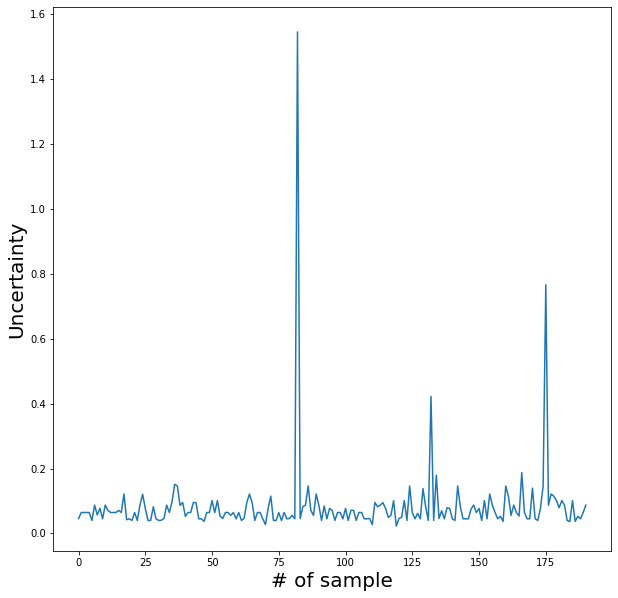

In [72]:
fig = plt.figure(figsize=(10,10))
plt.plot(uncertainty_ensemble)
plt.xlabel('# of sample', fontsize=20)
plt.ylabel('Uncertainty', fontsize=20)
plt.plot()